## 1. Descomprimimos el Dataset

In [9]:
import zipfile

zip_path = "C:/Users/Chris/Documents/Datasets/archive.zip"
extract_path = "C:/Users/Chris/Documents/Datasets/archive"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

  0%|          | 0/6129 [00:00<?, ?it/s]

100%|██████████| 6129/6129 [01:14<00:00, 82.58it/s] 


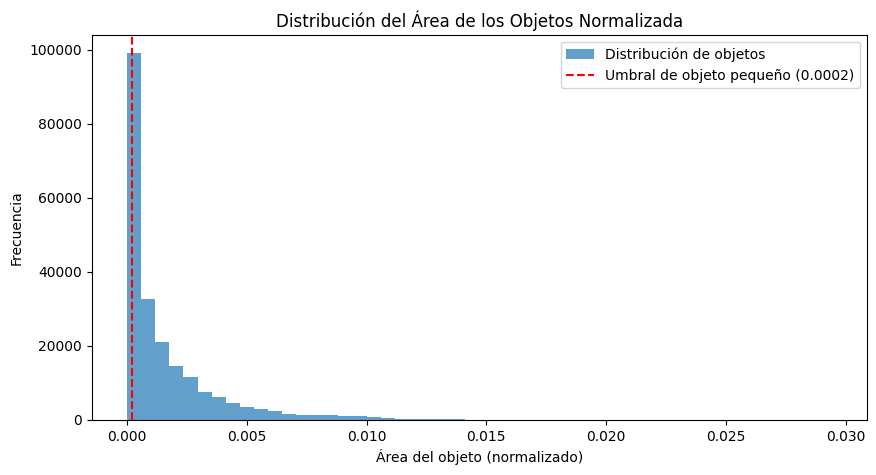

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

dataset_path = "C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3"

# Distribución de tamaños de los objetos en el dataset
def get_object_sizes(label_dir):
  sizes = []
  for label_file in tqdm(os.listdir(label_dir)[:6129]):  # Muestra parcial para acelerar procesamiento
    with open(os.path.join(label_dir, label_file), 'r') as f:
      for line in f:
        _, _, _, w, h = map(float, line.strip().split())  # Extraer ancho y alto del objeto
        sizes.append(w * h)  # Calcular el área del objeto
  return sizes

# Obtener tamaños de los objetos en el conjunto de entrenamiento
sizes = get_object_sizes(f"{dataset_path}/train/labels")

# Umbral dinámico para definir objetos pequeños (percentil 25)
small_threshold = np.percentile(sizes, 25)

# Gráfica de distribución de áreas de objetos
plt.figure(figsize=(10, 5))
plt.hist(sizes, bins=50, alpha=0.7, label='Distribución de objetos')
plt.axvline(small_threshold, color='r', linestyle='--', label=f'Umbral de objeto pequeño ({small_threshold:.4f})')
plt.title("Distribución del Área de los Objetos Normalizada")
plt.xlabel("Área del objeto (normalizado)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1845.02it/s]


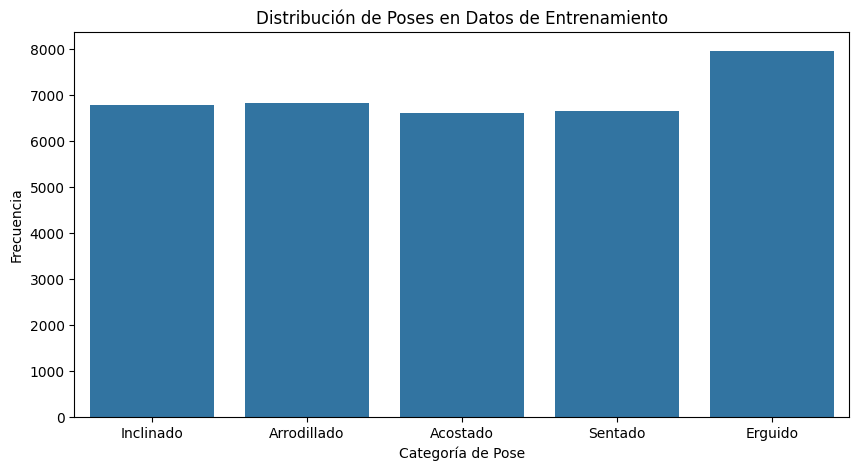

In [ ]:
import seaborn as sns

# Conteo de poses en el dataset
pose_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}  # 0: Inclinado, 1: Arrodillado, 2: Acostado, 3: Sentado, 4: Erguido

# Iterar sobre los archivos de etiquetas
label_dir = f"{dataset_path}/All labels with Pose information/labels"
for pose_file in tqdm(os.listdir(label_dir)[:1000]):  # Procesar una muestra para mejorar rendimiento
  file_path = os.path.join(label_dir, pose_file)
  with open(file_path, 'r') as f:
    for line in f:  # Leer todas las líneas del archivo
      parts = line.strip().split()
      if len(parts) > 5:  # Verificar si existe un ID de pose
        try:
          pose_id = int(parts[5])  # Extraer el ID de pose
          if pose_id in pose_counts:  # Asegurar que el ID es válido
            pose_counts[pose_id] += 1
        except (ValueError, IndexError):
          continue  # Omitir entradas inválidas

# Graficar la distribución de poses
plt.figure(figsize=(10, 5))
sns.barplot(x=list(pose_counts.keys()), y=list(pose_counts.values()))

# Actualizar etiquetas de los ejes
plt.xticks([0, 1, 2, 3, 4], ['Inclinado', 'Arrodillado', 'Acostado', 'Sentado', 'Erguido'])
plt.title("Distribución de Poses en Datos de Entrenamiento")
plt.xlabel("Categoría de Pose")
plt.ylabel("Frecuencia")
plt.show()

Crea la carpeta `working` en `C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3`

In [15]:
import yaml

# Configuración base del dataset C2A para entrenamiento con YOLO
base_yaml = {
  "path": dataset_path,  # Ruta raíz del dataset
  "train": f"{dataset_path}/train/images",  # Carpeta de imágenes de entrenamiento
  "val": f"{dataset_path}/val/images",  # Carpeta de imágenes de validación
  "names": {0: "Humano"},  # Clases en el dataset (solo una: 'Humano')
  "nc": 1,  # Número de clases en el dataset
  "augment": True  # Aplicación de aumentos de datos para mejorar la generalización
}

# Guardar la configuración en un archivo YAML
with open(f"{dataset_path}/working/c2a.yaml", "w") as f:
  yaml.dump(base_yaml, f)

In [16]:
with open(f"{dataset_path}/working/c2a.yaml", "r") as f:
  print(f.read())

augment: true
names:
  0: Humano
nc: 1
path: C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3
train: C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3/train/images
val: C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3/val/images



In [22]:
# Configuración para identificar objetos pequeños con un umbral dinámico
small_images = []

# Iterar sobre los archivos de etiquetas en el conjunto de entrenamiento
for label_file in tqdm(os.listdir(f"{dataset_path}/train/labels")[:6129]):  # Muestra parcial para eficiencia (6129/6129)
  with open(os.path.join(f"{dataset_path}/train/labels", label_file), 'r') as f:
    # Verificar si algún objeto en el archivo tiene un área menor al umbral definido
    if any(float(line.split()[3]) * float(line.split()[4]) < small_threshold for line in f):
      small_images.append(f"{dataset_path}/train/images/{label_file.replace('.txt', '.png')}")

# Guardar la lista de imágenes con objetos pequeños en un archivo de texto
with open(f"{dataset_path}/working/train_small.txt", "w") as f:
  f.write("\n".join(small_images))

  0%|          | 0/6129 [00:00<?, ?it/s]

100%|██████████| 6129/6129 [00:02<00:00, 2969.46it/s]


In [23]:
# Configuración para entrenamiento con objetos pequeños en el dataset C2A
small_yaml = {
    "path": dataset_path,  # Ruta raíz del dataset
    "train": f"{dataset_path}/train_small.txt",  # Lista de imágenes con objetos pequeños
    "val": f"{dataset_path}/val/images",  # Carpeta de imágenes de validación
    "names": {0: "Humano"},  # Clases en el dataset (solo una: 'Humano')
    "nc": 1,  # Número de clases en el dataset
    "augment": True,  # Activar aumentos de datos para mejorar la generalización
    "mosaic": 1.0  # Aumento con técnica de mosaico para mejorar la detección de objetos pequeños
}

# Guardar la configuración en un archivo YAML
with open(f"{dataset_path}/working/c2a_small.yaml", "w") as f:
    yaml.dump(small_yaml, f)

In [24]:
with open(f"{dataset_path}/working/c2a_small.yaml", "r") as f:
  print(f.read())

augment: true
mosaic: 1.0
names:
  0: Humano
nc: 1
path: C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3
train: C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3/train_small.txt
val: C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3/val/images



In [ ]:
from ultralytics import YOLO

# Cargar modelo preentrenado YOLOv8n (puede ser 'yolov9e', 'yolov9c', etc.)
model = YOLO('yolov9e.pt')

# Entrenar con los datos personalizados
model.train(
    data=f'{dataset_path}/working/c2a.yaml',
    epochs=25,
    imgsz=640,
    batch=16,
    project="/working",
    name='rafaBot_pose_detector1'
)

New https://pypi.org/project/ultralytics/8.3.151 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.37  Python-3.12.5 torch-2.5.1+cpu CPU (Intel Core(TM) i7-6500U 2.50GHz)
engine\trainer: task=detect, mode=train, model=yolov9e.pt, data=C:/Users/Chris/Documents/Datasets/archive/C2A_Dataset/new_dataset3/working/c2a.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/working, name=rafaBot_pose_detector12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnos

train: Scanning C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train\labels... 6129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6129/6129 [00:38<00:00, 157.22it/s]

train: WARNING  C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train\images\flood_image0407_3.png: 1 duplicate labels removed


train: New cache created: C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3\train\labels.cache


val: Scanning C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3\val\labels... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:23<00:00, 88.40it/s] 


val: New cache created: C:\Users\Chris\Documents\Datasets\archive\C2A_Dataset\new_dataset3\val\labels.cache
Plotting labels to \working\rafaBot_pose_detector12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to \working\rafaBot_pose_detector12
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/384 [00:00<?, ?it/s]